## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import Counter

## Loading data

In [2]:
df = pd.read_csv("../SQL/data/sentiment_analysis_bertimbau.csv", sep=",", quotechar='"', escapechar="\\")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df.shape

(33992, 3)

In [4]:
df.head(1)

,review_id,text_pt,label
0,00020c7512a52e92212f12d3e37513c0,A entrega foi super rápida e o pendente é lind...,2


## Duplicates/nulls/negative values check

In [5]:
df.duplicated(keep='first').sum()

0

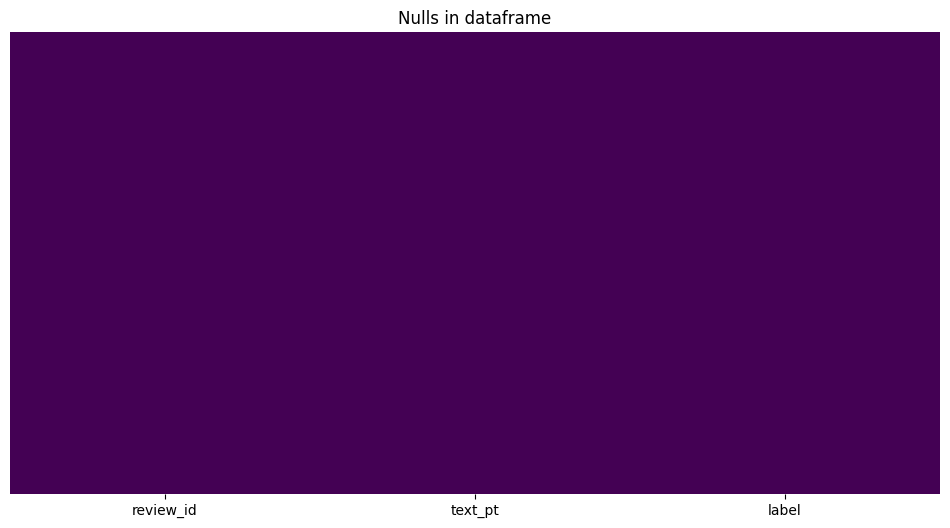

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Nulls in dataframe')
plt.savefig('../artifacts/images/sentiment_analysis_EDA/isnull_forecasting.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
for col in df.columns:
    n_missing = df[col].isna().sum()
    print(f"{col}: {n_missing} values")

review_id: 0 values
text_pt: 0 values
label: 0 values


In [8]:
df.dtypes

review_id    object
text_pt      object
label         int64
dtype: object

In [9]:
columns = [2]
negatives = (df.iloc[:,columns]< 0).any()
negatives

label    False
dtype: bool

##### NOTE: *There aren't any negative values or nulls.*

## Visualizations

C:\Users\Krzychu\AppData\Local\Temp\ipykernel_8624\3784589807.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis")


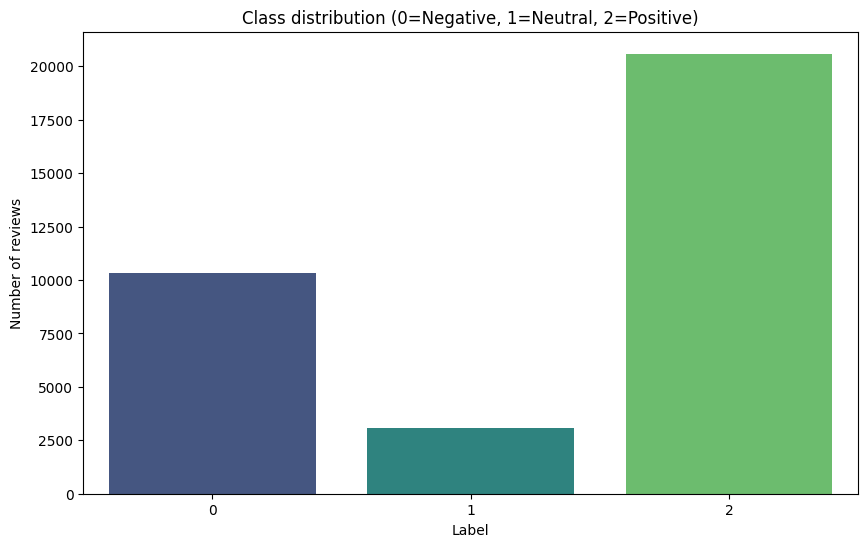

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="label", palette="viridis")
plt.title("Class distribution (0=Negative, 1=Neutral, 2=Positive)")
plt.xlabel("Label")
plt.ylabel("Number of reviews")
plt.savefig("../artifacts/images/sentiment_analysis_EDA/class_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
print("\nClass distribution (%):")
print(df["label"].value_counts(normalize=True))


Class distribution (%):
label
2    0.605525
0    0.303513
1    0.090963
Name: proportion, dtype: float64


##### NOTE: *Based on these 34,000 reviews, most of them are positive (rating 4 or 5), almost half are negative (1 or 2), and about 2,500 are neutral (3). This imbalance means the model may become biased toward positive sentiment.*

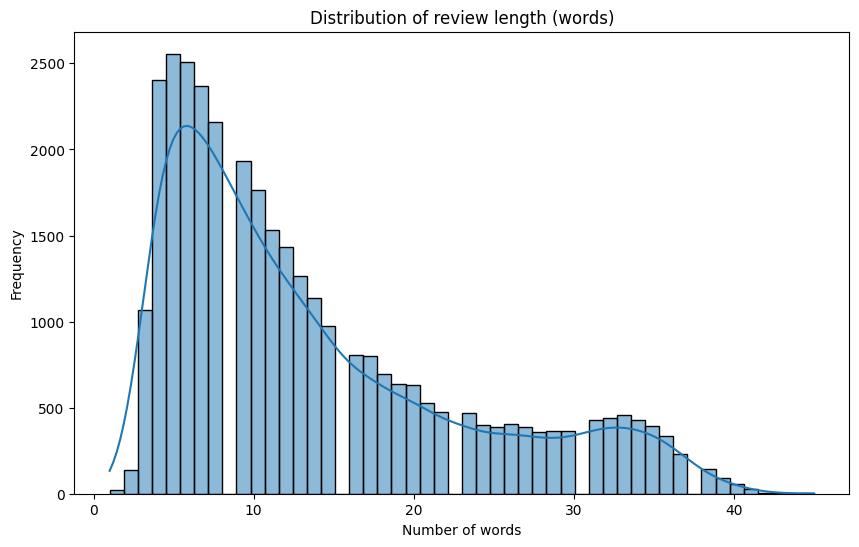

In [12]:
df["text_len_char"] = df["text_pt"].str.len()
df["text_len_words"] = df["text_pt"].str.split().apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df["text_len_words"], bins=50, kde=True)
plt.title("Distribution of review length (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.savefig("../artifacts/images/sentiment_analysis_EDA/review_length_words.png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
print("\nDescriptive statistics (characters):")
print(df["text_len_char"].describe())
print("\nDescriptive statistics (words):")
print(df["text_len_words"].describe())


Descriptive statistics (characters):
count    33992.000000
mean        79.574694
std         51.589156
min          5.000000
25%         39.000000
50%         63.000000
75%        106.000000
max        208.000000
Name: text_len_char, dtype: float64

Descriptive statistics (words):
count    33992.000000
mean        13.610938
std          9.277545
min          1.000000
25%          6.000000
50%         11.000000
75%         18.000000
max         45.000000
Name: text_len_words, dtype: float64


##### NOTE: *The majority of reviews are short (under 50 words), but some are much longer. This is typical of e-commerce feedback: many users just write “ótimo” (“great”), while others write long complaints. For BERT models, short inputs are not a problem, but long ones may need truncation.*

In [14]:
for label in [0,1,2]:
    print(f"\n📌 Example reviews for label={label}:")
    print(df[df["label"]==label]["text_pt"].sample(3, random_state=42).tolist())


📌 Example reviews for label=0:
['Comorei como 4 litros, mas a capacidade real é de 3.5 litros.', 'Simplesmente não recebi o produto', 'Não consegui obter informações sobre a entrega do produto']

📌 Example reviews for label=1:
['o produto não é tão bom ... achei meio ralezinho', 'Infelizmente o produto veio com defeito de fábrica e já acionei a devolução do produto', 'Meu otoscópio veio em uma caixa de péssima qualidade da Wellch, além de vir aberta. Produto tão mal-feito que parece até falsificado. Não veio estojo, tampouco pilhas. Péssimo.']

📌 Example reviews for label=2:
['Produto chegou no prazo de entrega veio bem embalado recomendo', 'Chegou dentro do prazo.', 'muito bom, recebi o produto antes do prazo estabelecido.']


C:\Users\Krzychu\AppData\Local\Temp\ipykernel_8624\2700571346.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[c for _, c in common_words], y=[w for w, _ in common_words], palette="viridis")


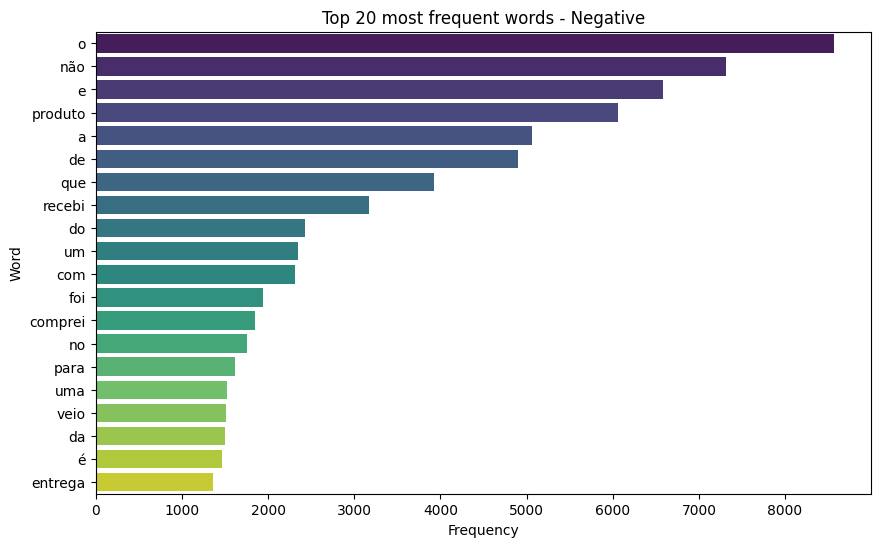

C:\Users\Krzychu\AppData\Local\Temp\ipykernel_8624\2700571346.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[c for _, c in common_words], y=[w for w, _ in common_words], palette="viridis")


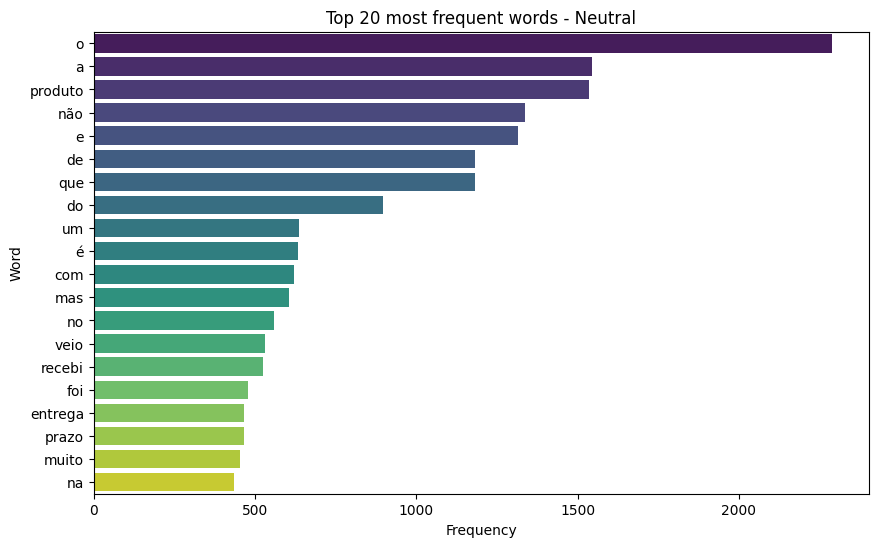

C:\Users\Krzychu\AppData\Local\Temp\ipykernel_8624\2700571346.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[c for _, c in common_words], y=[w for w, _ in common_words], palette="viridis")


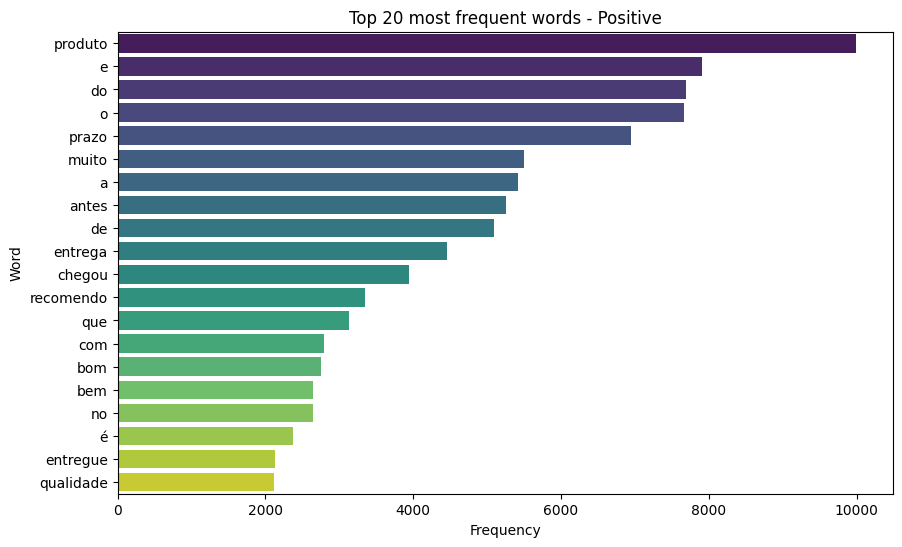

In [15]:
for label, title in zip([0,1,2], ["Negative", "Neutral", "Positive"]):
    texts = " ".join(df[df["label"] == label]["text_pt"].astype(str).tolist()).lower()
    words = re.findall(r"\b\w+\b", texts)
    common_words = Counter(words).most_common(20)

    plt.figure(figsize=(10,6))
    sns.barplot(x=[c for _, c in common_words], y=[w for w, _ in common_words], palette="viridis")
    plt.title(f"Top 20 most frequent words - {title}")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.savefig(f"../artifacts/images/sentiment_analysis_EDA/top_words_{title.lower()}.png", dpi=300, bbox_inches="tight")
    plt.show()

##### NOTE: *Frequent words in negative reviews are related to delay, defect, wrong product, etc. Neutral reviews often describe “ok” or “average” experiences. Positive reviews are dominated by “ótimo”, “excelente”, “bom”.*